## Identify all dependencies and set up

In [1]:
# Dependencies and Setup

# Python SQL toolkit and Object Relational Mapper - SQLAlchemy
import sqlalchemy
# To create an engine that can talk to the sqllite database
from sqlalchemy import create_engine, func, inspect
    
# To
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


# Pandas and NumPy
import pandas as pd
import numpy as np

# Datetime
import datetime as dt

# Matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
# Pyplot
import matplotlib.pyplot as plt

#

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Identify path to the SQLite database
database_path = "sqlite:///data/hawaii.sqlite"

# Create the engine that will talk to the sql db
engine = create_engine(database_path)

### Check what is in the database: Tables, their Columns & data types

In [4]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Using the inspector to print the column names of the 'measurement' table
# and its types
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Using the inspector to print the column names of the 'station' table
# and its types
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Reflect the database into a new model 

In [7]:
# Reflect the existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# View all of the classes that were auto-mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

## Exploratory Climate Analysis

## Precipitation Analysis: 

### Design a query to retrieve the last 12 months of precipitation data and plot the results.

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Calculate the date 1 year ago from the last data point in the database
# Find the Max date
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [11]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
                                  filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [12]:
# Save the query results as a Pandas DataFrame
precipitation_data_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation (inches)'])
precipitation_data_df

,date,precipitation (inches)
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [13]:
# Set the index to the date column.
precipitation_data_df.set_index('date', inplace = True)
precipitation_data_df

,precipitation (inches)
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [14]:
# Sort the dataframe by date
precipitation_data_df =precipitation_data_df.sort_values(by='date')
precipitation_data_df

,precipitation (inches)
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


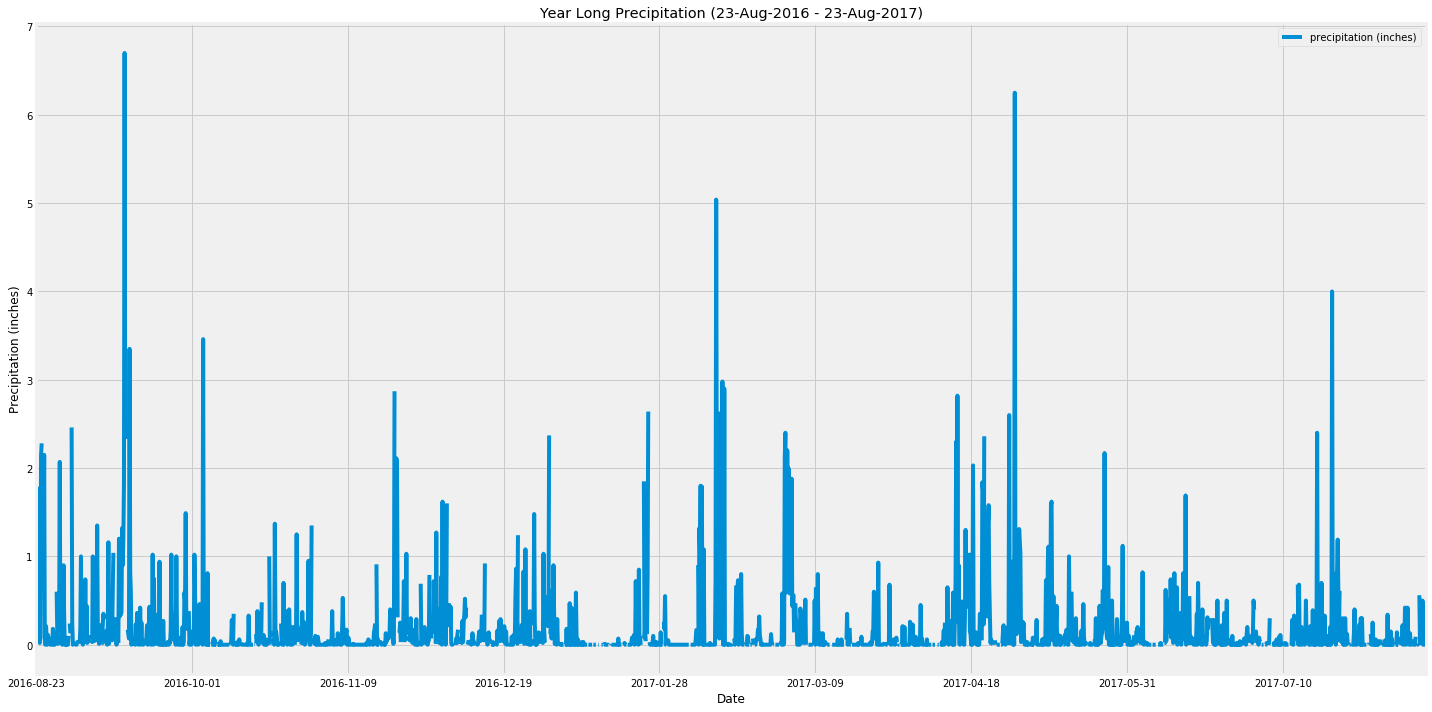

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize = (20, 10))
precipitation_data_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title("Year Long Precipitation (23-Aug-2016 - 23-Aug-2017)")

plt.savefig("Images/precipitation.png")

#plot
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_summary = precipitation_data_df.describe()
precp_summary

,precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis:

In [17]:
# Design a query to show how many stations are available in this dataset
station_count = session.query(Station.id).distinct().count()
station_count

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
all_station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
all_station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the following:
# 1) lowest temperature recorded, 
# 2) highest temperature recorded, and 
# 3) average temperature of the most active station
most_active_station = 'USC00519281'

mas_min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

mas_max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

mas_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Most Active Station (MAS) = {most_active_station}")

print (f"Lowest temperature at MAS: {mas_min_temp} Farenheit")
print (f"Highest temperature at MAS: {mas_max_temp} Farenheit")
print (f"Lowest temperature at MAS: {mas_avg_temp} Farenheit")

Most Active Station (MAS) = USC00519281
Lowest temperature at MAS: [(54.0,)] Farenheit
Highest temperature at MAS: [(85.0,)] Farenheit
Lowest temperature at MAS: [(71.66378066378067,)] Farenheit


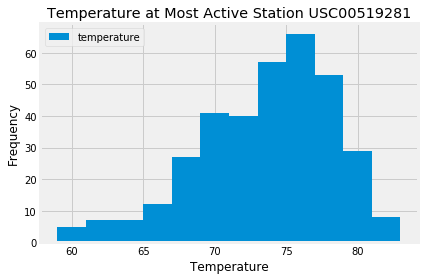

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
# and plot the results as a histogram

temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.title(f'Temperature at Most Active Station {most_active_station}')

#save figure
plt.savefig("Images/MAS_YearTemps.png")

#plot
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-05-02','2017-05-09')
trip_temps

[(66.0, 75.53333333333333, 80.0)]

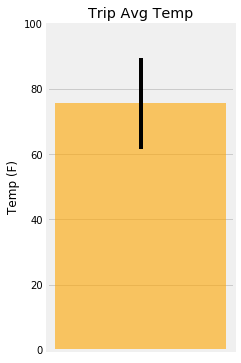

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-05-02'
end_date = '2017-05-09'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00519281
    Rainfall:  2.35  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  1.95  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00514830
    Rainfall:  1.91  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00516128
    Rainfall:  1.47  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519523
    Rainfall:  0.68  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.00  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168



# Optional Challenge Assignment

In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# Check for calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_normals = daily_normals("05-02")
trip_normals

[(65.0, 73.05084745762711, 79.0)]

In [ ]:
# Set the start and end date of the trip
start_date = '2020-05-02'
end_date = '2020-05-09'

# Use the start and end date to create a range of dates
# Calculate trip length
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# Strip off the year and save a list of %m-%d strings
# Start date as datetime object
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

# List dates (MM-DD) of trip
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

# Calculate dialy normals for each date
trip_Normals = [daily_normals(date) for date in dateList]

tripNormals

# Loop through the list of %m-%d strings and calculate the normals for each date

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
 # Plot the daily normals as an area plot with `stacked=False`